In [1]:
# Simulate a transit and optimize a fit.
# This uses the adaptive time-integrated quadratic-limb-darkening transit model.
# The path is a straight line of the planet across the star.

In [2]:
# Load in the functions for computing transit:

include("../src/integrate_lightcurve.jl")
include("../test/loglinspace.jl")

# Using the Optim.jl package:
using Optim

In [3]:
# Specify parameters appropriate for KOI-984.01.
# Plucking these from NexSci Kepler candidate archive.

# Radius ratio:
r = 0.025717
# Ratio of semi-major axis to stellar radius:
aonr = 19.94
# Orbital period [d]:
period = 4.28746668
# Impact parameter:
b0 = 0.374
# Transit duration [hr] (this is time between first and fourth contact):
T = 1.5693

# Check that these agree.  Compute velocity:
v = 2*pi*aonr/period
# Transit duration [convert to hr], approximate:
T0 = 2*sqrt((1+r)^2-b0^2)/v*24

println("T from NexSci: ",T," T computed: ",T0)

T from NexSci: 1.5693 T computed: 1.568868764493586


In [4]:
# Now to simulate transit.  Assume a 2-minute cadence:
tobs = 3*T  # Observation duration in hours
nobs = convert(Int64,round(tobs*30))  # Number of data points
tstep = linearspace(-1.5*T,1.5*T,nobs)  # Time array in units of hours

-2.3539499999999998:0.03362785714285714:2.3539499999999998

In [5]:
# Now compute the lightcurve.  We'll integrate a
# limb-darkened transit. Set the limb-darkening parameters:

u1 = 0.1914
u2 = 0.5167
u_n = [u1,u2]  # Quadratic limb-darkening parameters

2-element Array{Float64,1}:
 0.1914
 0.5167

In [6]:
# We'll use the function integrate_lightcurve to compute the light curve.
# First, we'll set the parameters of the transit:

trans = transit_init(r,b0,u_n,true)  # Initialize transit structure with radius
# ratio, an initial impact parameter value, limb-darkening parameter array, and
# whether we compute derivatives or not (in this case false)

param_path = [0.0,v/24,b0]   # Dynamical parameters of the transit: [t_0,v,b_0]
dt = 2/60  # Transit exposure time is 2 minutes, convert to hours.

# Set up arrays to hold various parameters:
favg1 = Array{Float64,2}(undef,7,nobs)  # Time-averaged flux per integration time, as well as gradient
maxdepth = 6  # Maximum depth of adaptive integration
neval_t = Array{Int64,1}(undef,nobs)  # Number of evaluations of transit model per integration
depthmax = Array{Int64,1}(undef,nobs)  # Maximum depth achieved during adaptive integration at each cadence
nt = nobs  # Number of observations = number of times
tol = 1e-6  # Tolerance set for adaptive integration
t = Array{Float64,1}(undef,nobs)
t .= tstep

# Create a simulated light curve, storing in favg1:
integrate_lightcurve!(trans,param_path,t,dt,favg1,nt,tol,maxdepth,neval_t,depthmax)

In [7]:
# Create an array to hold the five transit parameters:
# [r,t0,v,b0,q1,q2,f0]:
f0 = 1.0
param_original = [trans.r;param_path;u1;u2;f0]  # These are parameters for simulating the transit
param_path_original = copy(param_path)

3-element Array{Float64,1}:
 0.0              
 1.217567431384689
 0.374            

In [8]:
# Add noise to the data:
sigma = 2e-4
invsig2 = 1/sigma^2
# Add to the model flux Gaussian random noise with standard devation of sigma:
fobs = f0*favg1[1,:] .+ randn(nobs)*sigma;

In [9]:
# Create a closure function to carry out the optimization:
function optimize_transit(trans,param_path,param_all,t,fobs,favg1,dt,nt,tol,maxdepth)
    # Create a function to compute the likelihood called by Optim.
    # This is written to avoid re-computation of function and gradient
    # See here for the code this was modelled after: 
    #    http://julianlsolvers.github.io/Optim.jl/stable/#user/tipsandtricks/
    function compute_likelihood!(F,G,param_all)
        # Pass parameters from param_all to transit structure:
        trans = transit_init(param_all[1],param_all[4],param_all[5:6],true)
        param_path .= param_all[2:4]  # Pass the dynamical parameters to param_path
        # Set the unocculted flux:
        f0 = param_all[7]
        # Integrate the lightcurve:
        integrate_lightcurve!(trans,param_path,t,dt,favg1,nt,tol,maxdepth,neval_t,depthmax)
        # Return the gradient of the chi-square:
        if G != nothing
            fill!(G,0.0)
            nG = size(G)[1]
            for j=1:nG-1
                # Compute gradient by taking dot product of residual vector with gradient:
                G[j] += -2*dot((fobs.-f0*favg1[1,:]),f0*favg1[1+j,:])*invsig2
            end
            G[nG] = -2*dot((fobs.-f0*favg1[1,:]),favg1[1,:])*invsig2
        end
        if F != nothing
            # Compute the negative log-likelihood, which in this case is the chi-square:
            nll = sum((fobs.-f0*favg1[1,:]).^2)*invsig2
            return nll
        end 
    end
    # Set bounds:
    lower = [1e-3,-1.0,1e-3,0.0,0.0,0.0,0.5]
    upper = [1e3,  1.0,1e3, 1.1,1.0,1.0,2.0]
    # Now, optimize the fit to the data:
    inner_optimizer = LBFGS()
    #result = Optim.optimize(Optim.only_fg!(compute_likelihood!),lower,upper,param_all,Optim.LBFGS())
    result = Optim.optimize(Optim.only_fg!(compute_likelihood!),lower,upper,param_all,Fminbox(inner_optimizer))
    return result
end

optimize_transit (generic function with 1 method)

In [10]:
# Set the initial conditions. First, copy over the correct parameters:
param_all = copy(param_original)

# Add some random offset values to the intitial conditions:
param_all[1] *= (1+randn()*0.1)   # Add 10% error to radius
param_all[2] += randn()*0.3       # Add 18-minute error to initial time
param_all[3] *= (1+randn()*0.1)   # Add 10% error to velocity
param_all[4:6] = rand(3)          # Randomly choose impact parameter & limb-darkening params between 0 and 1
param_all[7] *= (1+randn()*0.0003) # Add 0.03% error to the unocculted flux



# Compute perturbed lightcurve:
trans_pert = transit_init(param_all[1],param_all[4],param_all[5:6],true)
param_path_pert = param_all[2:4]
favg_pert = copy(favg1)

integrate_lightcurve!(trans_pert,param_path_pert,t,dt,favg_pert,nt,tol,maxdepth,neval_t,depthmax)
favg_pert[1,:] *= param_all[7]

141-element Array{Float64,1}:
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 ⋮                 
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197
 1.0002546214021197

In [11]:
# Copy the flux & derivative array:
favg2 = copy(favg1)
# Optimize the result:
result =  optimize_transit(trans_pert,param_path_pert,param_all,t,fobs,favg2,dt,nt,tol,maxdepth)

# NOTE:  Sometimes the intitial "perturbed" parameters will be so far off that
# the optimization fails.  In this case, rerun the prior cell and this cell
# until the optimization succeeds.

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.02014404876033681,0.06727589315305517, ...]
 * Minimizer: [0.02544652421441487,0.009684320418497393, ...]
 * Minimum: 1.373465e+02
 * Iterations: 8
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 5.71e-01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 8232
 * Gradient Calls: 8232

In [12]:
param_all_final = Optim.minimizer(result)

7-element Array{Float64,1}:
 0.02544652421441487   
 0.009684320418497393  
 1.1866701055191495    
 0.4631980459377428    
 0.013990389922080378  
 4.0069662074883184e-16
 0.9999650616938898    

In [13]:
param_path_final = param_all_final[2:4]
trans_final = transit_init(param_all_final[1],param_all_final[4],param_all_final[5:6],true)
integrate_lightcurve!(trans_final,param_path_final,t,dt,favg2,nt,tol,maxdepth,neval_t,depthmax)
favg2[1,:] *= param_all_final[7];

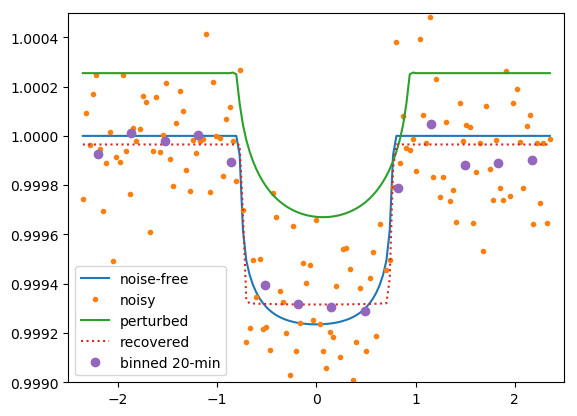

4-element Array{Float64,1}:
 -2.5   
  2.5   
  0.999 
  1.0005

In [14]:
# Plot noise-free light curve:
using PyPlot
using Statistics
clf()
plot(t,favg1[1,:], label="noise-free")

# Plot noisy curve:
plot(t,fobs,".",label="noisy")

# Plot "perturbed" lightcurve (with initial guessed parameters):
plot(t,favg_pert[1,:],label="perturbed")

# Plot best-fit curve:
plot(t,favg2[1,:],label="recovered",linestyle=":")

# Plot binned data:
tbin = zeros(14); fbin = zeros(14)
for i=1:14
    tbin[i] = mean(t[(i-1)*10+1:i*10])
    fbin[i] = mean(fobs[(i-1)*10+1:i*10])
end
# Plot binned points with large dots:
plot(tbin,fbin,"o",label="binned 20-min")
legend()
axis([-2.5,2.5,0.999,1.0005])


In [194]:
param_original

7-element Array{Float64,1}:
 0.025717         
 0.0              
 1.217567431384689
 0.374            
 0.1914           
 0.5167           
 1.0              

In [195]:
param_all_final

7-element Array{Float64,1}:
 0.024788760648733314 
 0.003630846469602858 
 1.2736956296103525   
 4.903587869840479e-6 
 0.6814255422378264   
 3.3592464613253033e-9
 0.9999804563650685   

In [196]:
param_original-param_all_final

7-element Array{Float64,1}:
  0.0009282393512666867
 -0.003630846469602858 
 -0.05612819822566362  
  0.37399509641213013  
 -0.49002554223782635  
  0.5166999966407536   
  1.9543634931507015e-5

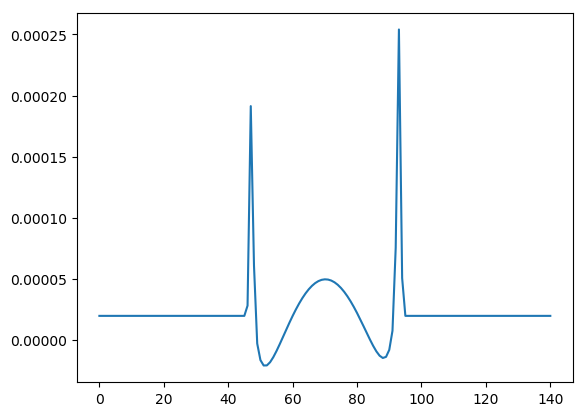

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x144993eb8>

In [197]:
plot(favg1[1,:]-favg2[1,:])

In [198]:
param_path_original

3-element Array{Float64,1}:
 0.0              
 1.217567431384689
 0.374            

In [199]:
param_path_final

3-element Array{Float64,1}:
 0.003630846469602858
 1.2736956296103525  
 4.903587869840479e-6